In [15]:
import igraph as ig
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from auxiliar_bb import apply_backboning
from auxiliar_projections_large import apply_projection
from auxiliar_optimization import *
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [7]:
### Select dataset
DATASET = "um" # ["amz", "um", "am"]
PROJ_NAMES = ["master", "hyper", "resall"]

if DATASET == "um":
    FILENAME = "../12-third_year/00-Data/08-imdb/user-movie.graphml"
elif DATASET == "am":
    FILENAME = "/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/00-Data/05-actor-movie/actor-movie.graphml"
elif DATASET == "amz":
    FILENAME = "binet-AMZ-Rw.graphml"


### Load dataset

In [3]:
g = ig.read(FILENAME)
print(g.summary())
print()

top_nodes = g.vs.select(type=0)
bot_nodes = g.vs.select(type=1)

print("|U|=",len(top_nodes), " \t|R|=",len(bot_nodes), " \t|U|+|R|=",
      len(top_nodes)+len(bot_nodes), "=", g.vcount())
print()

if(g.is_bipartite()): # Check if the the graph is bipartite
    print("The graph IS bipartite")
else:
    print("The graph IS NOT bipartite")
    exit()


IGRAPH UN-T 1199919 3782463 -- 
+ attr: id (v), name (v), type (v)

|U|= 896302  	|R|= 303617  	|U|+|R|= 1199919 = 1199919

The graph IS bipartite


### Apply projection and backboning

In [8]:
for proj_opcion in PROJ_NAMES:
    ###### ****** Projections ****** ######
    top_graph = apply_projection(g, proj_opcion,
                                len(top_nodes), False) # False = Users = 0
    print("Done PROJ1 - Users Projection")
    edges_temp = top_graph.es()["weight"]
    print(f"Peso máximo={max(edges_temp)} y mínimo={min(edges_temp)} en aristas: ")

    bot_graph = apply_projection(g, proj_opcion,
                                len(top_nodes), True) # True = Resources = 1
    print("\nDone PROJ2 - Resources Projection")
    edges_temp = bot_graph.es()["weight"]
    print(f"Peso máximo={max(edges_temp)} y mínimo={min(edges_temp)} en aristas: ")
    print()

    ### Applying backboning
    for i, graph_type in enumerate([top_graph, bot_graph]):
        apply_backboning(graph_type, dataset="um", proj_opcion=proj_opcion, nodetype=i, remove_zeros=False)
    

Done PROJ1 - Users Projection
Peso máximo=1.0 y mínimo=0.0 en aristas: 

Done PROJ2 - Resources Projection
Peso máximo=0.5 y mínimo=0.0 en aristas: 


##### **** BACKBONING USERS **** #####
Projection Name: master
Summary
 IGRAPH UNWT 896302 57064358 -- 
+ attr: id (v), name (v), type (v), weight (e)
##### END #####

Peso máximo=1.0 y mínimo=0.0 en aristas: 

Factor de escala: 234
Peso máximo=234 y mínimo=1 en aristas: 

TOP DF - time: 19.9129877090 seconds.
Grafo filtrado con alpha=0.05: IGRAPH UNWT 896100 17085 -- 
+ attr: id (v), name (v), type (v), weight (e)
Grafo filtrado con alpha=0.1: IGRAPH UNWT 896100 17304 -- 
+ attr: id (v), name (v), type (v), weight (e)
Grafo filtrado con alpha=0.15: IGRAPH UNWT 896100 17386 -- 
+ attr: id (v), name (v), type (v), weight (e)
Grafo filtrado con alpha=0.2: IGRAPH UNWT 896100 17395 -- 
+ attr: id (v), name (v), type (v), weight (e)
TOP NC - time: 77.4468693733 seconds.
Grafo filtrado con alpha=0.05: IGRAPH UNWT 896302 56895091 -- 
+ attr: id

## Optimization Type 0

In [9]:
NODETYPE = 0    # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
bip_metrics = compute_bip_metrics(gb, NODETYPE)
bip_metrics

/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /


{'x1': 896302,
 'x2': 303617,
 'x3': 3782463,
 'x8': 1,
 'x9': 6.932824792152002,
 'x11': 4.405520882159655}

In [10]:
# 2) Escanear carpeta de proyecciones
if NODETYPE == 0:
    proj_dir = DATASET+"/top"    
else:
    proj_dir = DATASET+"/bot" 
    
proj_files = [f for f in os.listdir(proj_dir) if f.endswith(".graphml")]


# 3) Calcular soluciones
solutions = []
to_df = []
names_df = []
k = 100 # For approximation

for fname in proj_files:
    gu = ig.Graph.Read_GraphML(os.path.join(proj_dir, fname))
    gu = remove_isolated_nodes(gu, k=5)

    # For approximation
    if k < gu.vcount():
        proj_metrics = compute_proj_metrics(gu,k)
    else:
        proj_metrics = compute_proj_metrics(gu,gu.vcount())
    
    
    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(fname[:-8])
    sol["filename"] = fname[:-8]
    
    if is_feasible(sol):
        solutions.append(sol)

### Creation of dataset    
a = pd.DataFrame(to_df)
b = pd.DataFrame(names_df)
a.columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
b.columns = ["name"]
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(proj_files))
print("Feasible solutions:", len(solutions))

All solutions: 32
Feasible solutions: 16


In [11]:
### Compute the pareto fronts

all_fronts = pareto_rank_all(solutions)

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")


Frente 1 (14 soluciones):

Frente 2 (2 soluciones):


In [12]:
cd = crowding_distance(all_fronts[0])
pareto_sorted = [s for _, s in sorted(zip(-cd, all_fronts[0]), key=lambda x: x[0])]
print("Crowding", len(pareto_sorted))

Crowding 14


### Plotting

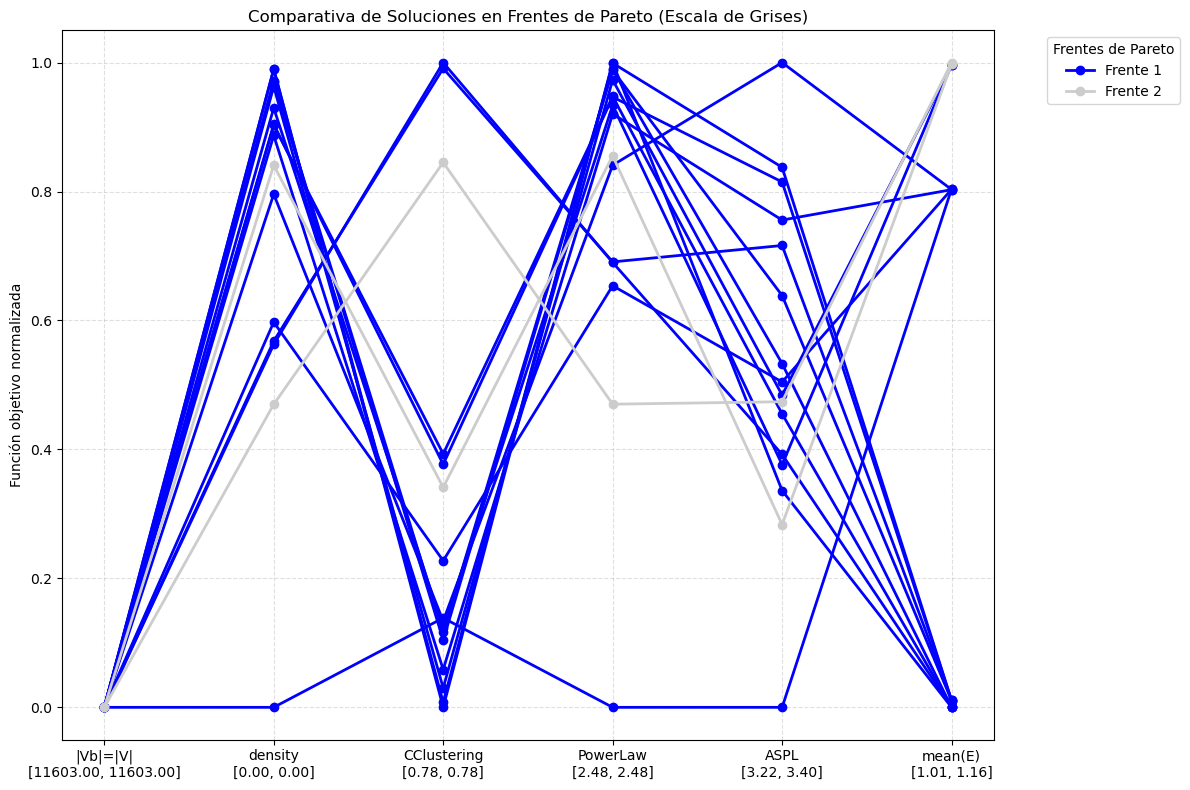

In [13]:
# --- Fin de la simulación de datos ---

labels = ["|Vb|=|V|", "density", "CClustering", "PowerLaw", "ASPL", "mean(E)"]

# 1. Aplanar la lista de frentes para normalizar todos los datos juntos
todas_las_soluciones = [sol for front in all_fronts for sol in front]
F_all = np.array([sol["f"] for sol in todas_las_soluciones])

# 2. Calcular los valores mínimo y máximo de cada función objetivo
min_vals = F_all.min(axis=0)
max_vals = F_all.max(axis=0)

# 3. Normalizar todos los valores
F_norm_all = (F_all - min_vals) / (max_vals - min_vals + 1e-8)

# 4. Preparar la figura para la gráfica
plt.figure(figsize=(12, 8))

# Generar una escala de grises
num_frentes = len(all_fronts)
# Usar `np.linspace` para generar valores de gris desde un tono oscuro a uno claro.
# Por ejemplo, desde un gris 0.2 (oscuro) hasta 0.8 (claro).
gray_scale = np.linspace(0.2, 0.8, num_frentes)

# 5. Recorrer los frentes y las soluciones para graficar
idx_solucion = 0
for i, front in enumerate(all_fronts):
    rank = i + 1
    # Asignar el color de la escala de grises al frente actual
    if i == 0:
        color = "blue"
    else:
        color = str(gray_scale[i])
    
    for j, sol in enumerate(front):
        F_norm_solucion = F_norm_all[idx_solucion]
        
        # Etiquetar solo el primer grafo de cada frente para la leyenda
        if j == 0:
            label = f"Frente {rank}"
        else:
            label = None

        plt.plot(
            labels,
            F_norm_solucion,
            color=color,
            linestyle='-',
            linewidth=2,
            marker='o',
            label=label
        )
        
        idx_solucion += 1

# 6. Actualizar las etiquetas del eje X con los rangos de valores reales
new_labels = [f"{lbl}\n[{min_v:.2f}, {max_v:.2f}]" for lbl, min_v, max_v in zip(labels, min_vals, max_vals)]
plt.xticks(range(len(new_labels)), new_labels, rotation=0)

# 7. Configurar y guardar la gráfica
plt.ylabel("Función objetivo normalizada")
plt.title("Comparativa de Soluciones en Frentes de Pareto (Escala de Grises)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Frentes de Pareto", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("frentes_de_pareto_grises.png")
plt.show()


### Plotting Dimensionality Reduction

In [1]:
points = []
labels = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)  # índice de frente

# Apply t-SNE
tsne_2d = TSNE(n_components=2, perplexity=10, random_state=42, init='pca', learning_rate='auto')
embedding_2d = tsne_2d.fit_transform(points)

tsne_3d = TSNE(n_components=3, perplexity=10, random_state=42, init='pca', learning_rate='auto')
embedding_3d = tsne_3d.fit_transform(points)

# Create subplots
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 2, 1) # 2D subplot

# Plot 2D
scatter_2d = ax1.scatter(embedding_2d[:, 0], embedding_2d[:, 1],
                         c=labels, cmap="tab10", s=50, edgecolors='k')
ax1.set_title("Visualización t-SNE 2D")
ax1.set_xlabel("t-SNE componente 1")
ax1.set_ylabel("t-SNE componente 2")
ax1.grid(True, linestyle="--", alpha=0.3)
ax1.legend(*scatter_2d.legend_elements(), title="Frente", loc="upper right")

# Plot 3D
ax2 = fig.add_subplot(1, 2, 2, projection='3d') # 3D subplot
scatter_3d = ax2.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2],
                         c=labels, cmap="tab10", s=50, edgecolors='k')
ax2.set_title("Visualización t-SNE 3D")
ax2.set_xlabel("t-SNE componente 1")
ax2.set_ylabel("t-SNE componente 2")
ax2.set_zlabel("t-SNE componente 3")
ax2.legend(*scatter_3d.legend_elements(), title="Frente", loc="upper right")


print("Se ha generado el gráfico tsne_subplots.png con las dos visualizaciones.")

NameError: name 'all_fronts' is not defined

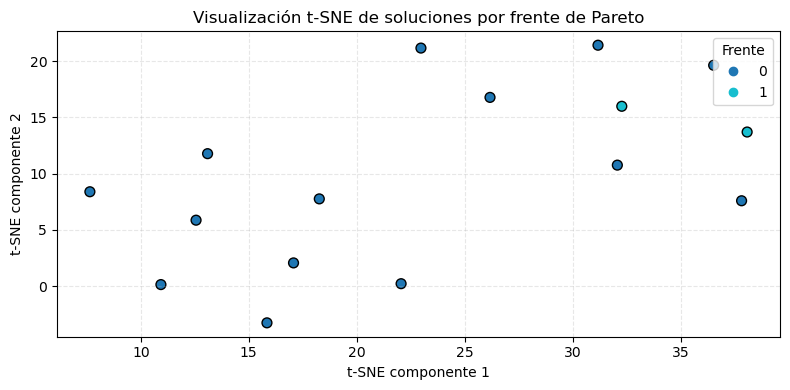

In [ ]:
points = []
labels = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)  # índice de frente

points = np.array(points)
labels = np.array(labels)

# Aplicar t-SNE
tsne = TSNE(n_components=2, perplexity=10, random_state=42) # 2D
embedding = tsne.fit_transform(points)

tsne3d = TSNE(n_components=3, perplexity=10, random_state=42) # 3D
embedding3d = tsne3d.fit_transform(points)


# Graficar
plt.figure(figsize=(8, 4))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=labels, cmap="tab10", s=50, edgecolors='k')

plt.title("Visualización t-SNE de soluciones por frente de Pareto")
plt.xlabel("t-SNE componente 1")
plt.ylabel("t-SNE componente 2")
plt.grid(True, linestyle="--", alpha=0.3)
legend = plt.legend(*scatter.legend_elements(), title="Frente", loc="upper right")
plt.tight_layout()
plt.show()

### Aplicar las subfiguras con los dos con tsne

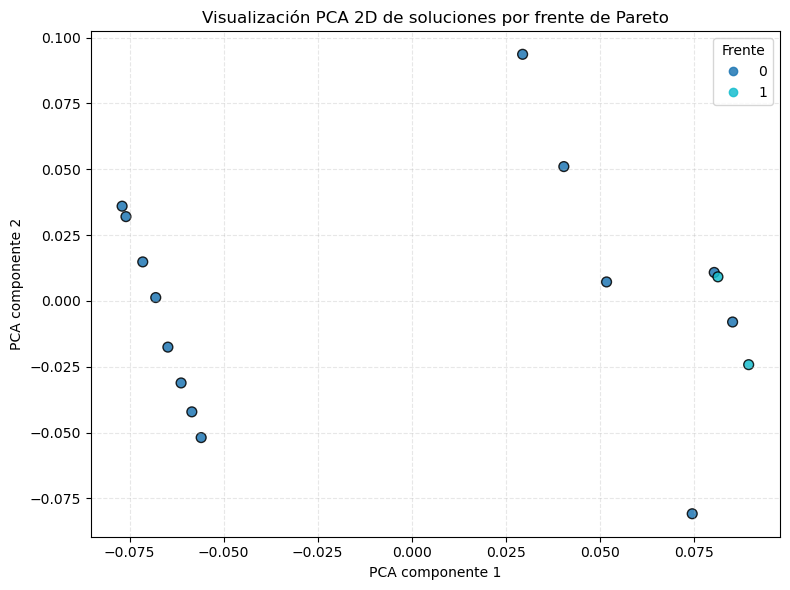

In [17]:
points = []
labels = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)

points = np.array(points)
labels = np.array(labels)

pca = PCA(n_components=2)
pca3d = PCA(n_components=3)
embedding = pca.fit_transform(points)
embedding3d = pca3d.fit_transform(points)

# Graficar
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=labels, cmap="tab10", s=50, edgecolors='k', alpha=0.85)

plt.title("Visualización PCA 2D de soluciones por frente de Pareto")
plt.xlabel("PCA componente 1")
plt.ylabel("PCA componente 2")
plt.grid(True, linestyle="--", alpha=0.3)
legend = plt.legend(*scatter.legend_elements(), title="Frente", loc="upper right")
plt.tight_layout()
plt.show()


## Optimization type 1

In [26]:
NODETYPE = 1    # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
bip_metrics = compute_bip_metrics(gb, NODETYPE)
bip_metrics

/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /


{'x1': 896302,
 'x2': 303617,
 'x3': 3782463,
 'x8': 1,
 'x9': 6.929858668716832,
 'x11': 4.218614669633543}

In [27]:
# 2) Escanear carpeta de proyecciones
if NODETYPE == 0:
    proj_dir = DATASET+"/top"    
else:
    proj_dir = DATASET+"/bot" 
    
proj_files = [f for f in os.listdir(proj_dir) if f.endswith(".graphml")]


# 3) Calcular soluciones
solutions = []
to_df = []
names_df = []
k = 100 # For approximation

for fname in proj_files:
    gu = ig.Graph.Read_GraphML(os.path.join(proj_dir, fname))
    gu = remove_isolated_nodes(gu, k=5)

    # For approximation
    if k < gu.vcount():
        proj_metrics = compute_proj_metrics(gu,k)
    else:
        proj_metrics = compute_proj_metrics(gu,gu.vcount())
    
    
    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(fname[:-8])
    sol["filename"] = fname[:-8]
    
    if is_feasible(sol):
        solutions.append(sol)

### Creation of dataset    
a = pd.DataFrame(to_df)
b = pd.DataFrame(names_df)
a.columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
b.columns = ["name"]
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(proj_files))
print("Feasible solutions:", len(solutions))

All solutions: 32
Feasible solutions: 22


In [28]:
### Compute the pareto fronts

all_fronts = pareto_rank_all(solutions)

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")


Frente 1 (22 soluciones):


In [29]:
cd = crowding_distance(all_fronts[0])
pareto_sorted = [s for _, s in sorted(zip(-cd, all_fronts[0]), key=lambda x: x[0])]
print("Crowding", len(pareto_sorted))

Crowding 22


### Plotting

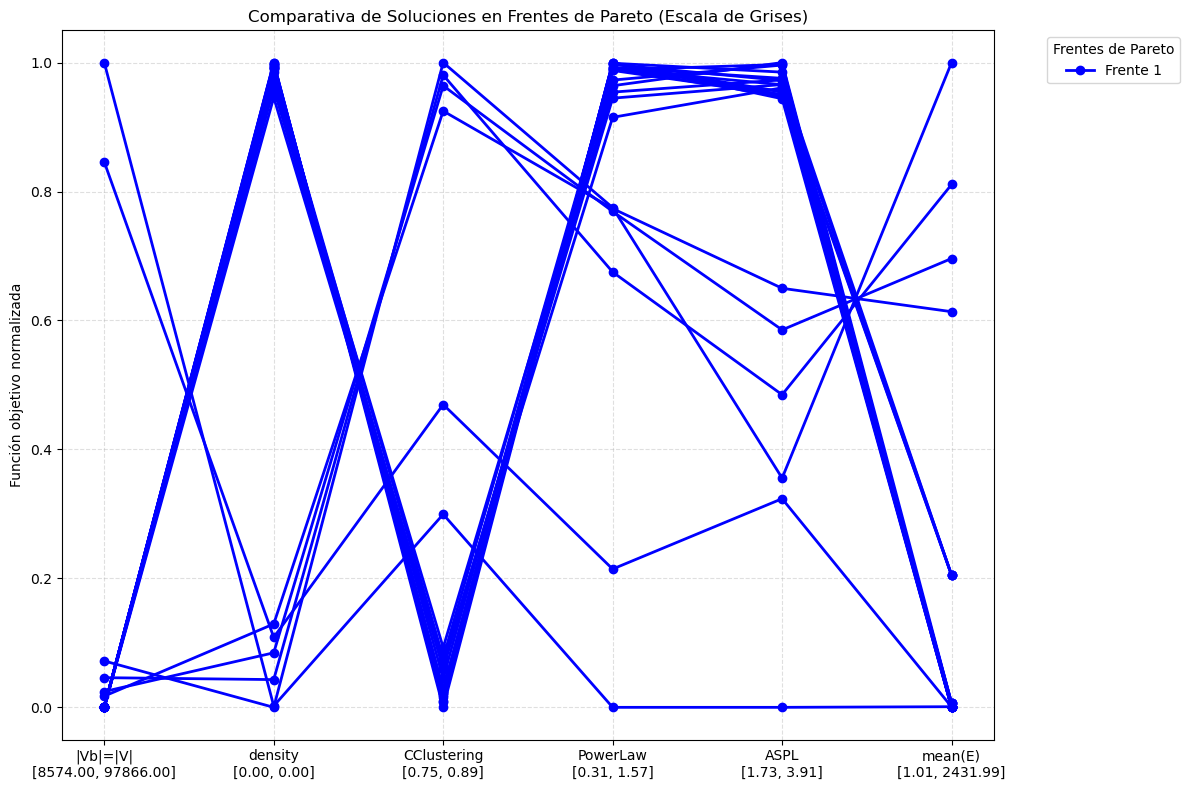

In [30]:
# --- Fin de la simulación de datos ---

labels = ["|Vb|=|V|", "density", "CClustering", "PowerLaw", "ASPL", "mean(E)"]

# 1. Aplanar la lista de frentes para normalizar todos los datos juntos
todas_las_soluciones = [sol for front in all_fronts for sol in front]
F_all = np.array([sol["f"] for sol in todas_las_soluciones])

# 2. Calcular los valores mínimo y máximo de cada función objetivo
min_vals = F_all.min(axis=0)
max_vals = F_all.max(axis=0)

# 3. Normalizar todos los valores
F_norm_all = (F_all - min_vals) / (max_vals - min_vals + 1e-8)

# 4. Preparar la figura para la gráfica
plt.figure(figsize=(12, 8))

# Generar una escala de grises
num_frentes = len(all_fronts)
# Usar `np.linspace` para generar valores de gris desde un tono oscuro a uno claro.
# Por ejemplo, desde un gris 0.2 (oscuro) hasta 0.8 (claro).
gray_scale = np.linspace(0.2, 0.8, num_frentes)

# 5. Recorrer los frentes y las soluciones para graficar
idx_solucion = 0
for i, front in enumerate(all_fronts):
    rank = i + 1
    # Asignar el color de la escala de grises al frente actual
    if i == 0:
        color = "blue"
    else:
        color = str(gray_scale[i])
    
    for j, sol in enumerate(front):
        F_norm_solucion = F_norm_all[idx_solucion]
        
        # Etiquetar solo el primer grafo de cada frente para la leyenda
        if j == 0:
            label = f"Frente {rank}"
        else:
            label = None

        plt.plot(
            labels,
            F_norm_solucion,
            color=color,
            linestyle='-',
            linewidth=2,
            marker='o',
            label=label
        )
        
        idx_solucion += 1

# 6. Actualizar las etiquetas del eje X con los rangos de valores reales
new_labels = [f"{lbl}\n[{min_v:.2f}, {max_v:.2f}]" for lbl, min_v, max_v in zip(labels, min_vals, max_vals)]
plt.xticks(range(len(new_labels)), new_labels, rotation=0)

# 7. Configurar y guardar la gráfica
plt.ylabel("Función objetivo normalizada")
plt.title("Comparativa de Soluciones en Frentes de Pareto (Escala de Grises)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Frentes de Pareto", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("frentes_de_pareto_grises.png")
plt.show()


### Plotting Dimensionality Reduction

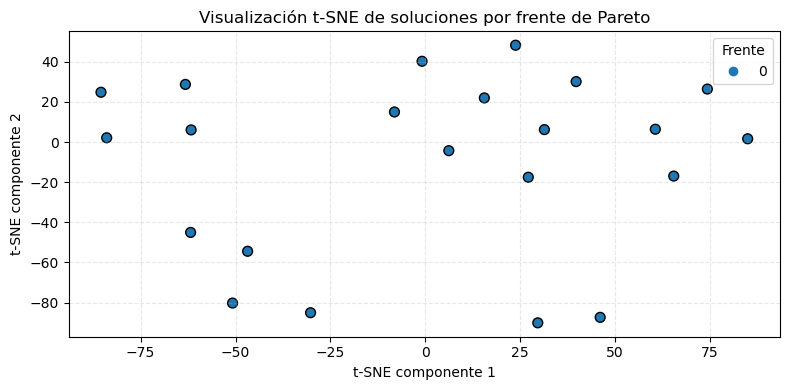

In [31]:
points = []
labels = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)  # índice de frente

points = np.array(points)
labels = np.array(labels)

# Aplicar t-SNE
tsne = TSNE(n_components=2, perplexity=10, random_state=42) # 2D
embedding = tsne.fit_transform(points)
tsne3d = TSNE(n_components=3, perplexity=10, random_state=42) # 3D
embedding3d = tsne3d.fit_transform(points)


# Graficar
plt.figure(figsize=(8, 4))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=labels, cmap="tab10", s=50, edgecolors='k')

plt.title("Visualización t-SNE de soluciones por frente de Pareto")
plt.xlabel("t-SNE componente 1")
plt.ylabel("t-SNE componente 2")
plt.grid(True, linestyle="--", alpha=0.3)
legend = plt.legend(*scatter.legend_elements(), title="Frente", loc="upper right")
plt.tight_layout()
plt.show()

### Aplicar las subfiguras con los dos con tsne

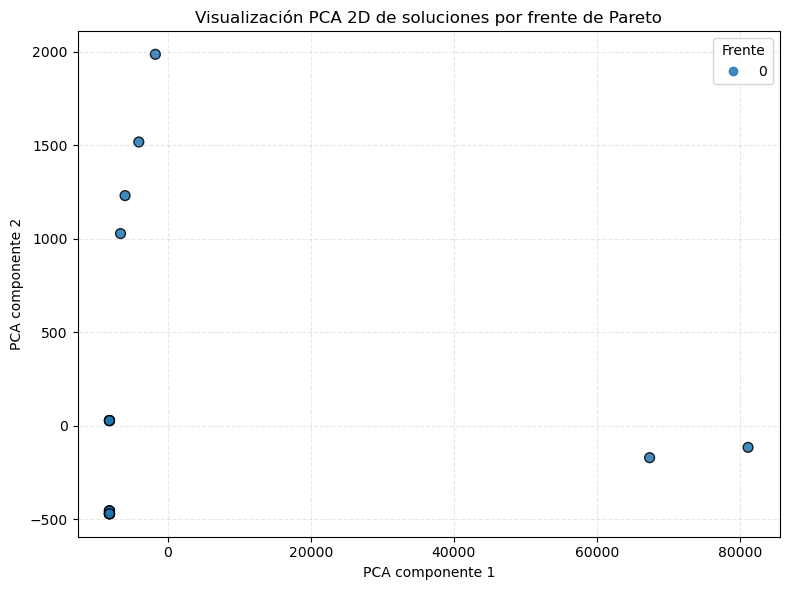

In [32]:
points = []
labels = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)

points = np.array(points)
labels = np.array(labels)

pca = PCA(n_components=2)
pca3d = PCA(n_components=3)
embedding = pca.fit_transform(points)
embedding3d = pca3d.fit_transform(points)

# Graficar
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=labels, cmap="tab10", s=50, edgecolors='k', alpha=0.85)

plt.title("Visualización PCA 2D de soluciones por frente de Pareto")
plt.xlabel("PCA componente 1")
plt.ylabel("PCA componente 2")
plt.grid(True, linestyle="--", alpha=0.3)
legend = plt.legend(*scatter.legend_elements(), title="Frente", loc="upper right")
plt.tight_layout()
plt.show()
